### 1. Общие

ALS
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа (https://dyakonov.org/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/)
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

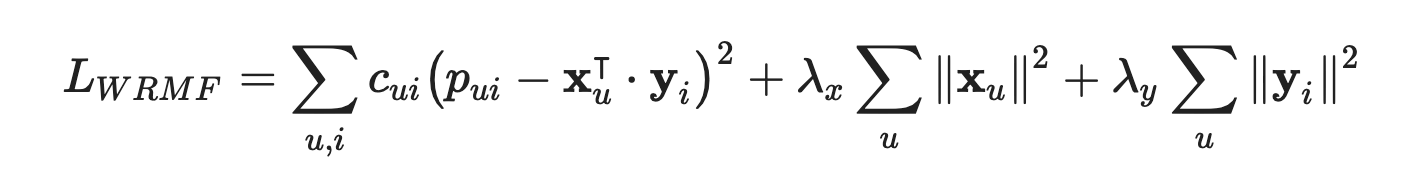

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных interactions, минимизирует для негативных

**Скалярное призведение (dot product) VS косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

**_prompt_**

Важно различать __модель__ (бустинг, random forest, линейная, полносвязная нейросеть, SVM) и __функцию потерь__ (loss) (RMSE, logloss, энтропия, WARP). Иногда под моделью сразу понимается модель+функция потерь. Например, логистическая регрессия.


### 4. Как использовать для ранжирования (Краткое введение. Подробности - на следующем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{uj} - p_{ui})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

In [1]:
from implicit.bpr import BayesianPersonalizedRanking

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

In [78]:
def prefilter_items(data_train, n_popular=150, n_unpopular=1000, departments=[],\
                    min_value=0, max_value=np.inf):
    # Оставим только 5000 самых популярных товаров
    popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
    #добавим, чтобы не потерять юзеров
    data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999 
    

    # Уберем самые популярные 
    without_popular = top_5000[n_popular:]
    data_train.loc[~data_train['item_id'].isin(without_popular), 'item_id'] = 999999 
    
    # Уберем самые непопулряные 
    n = 5000 - n_popular - n_unpopular
    without_unpopular = without_popular[:n]
    data_train.loc[~data_train['item_id'].isin(without_unpopular), 'item_id'] = 999999 
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    data_train.loc[data_train['day'] <= 365, 'item_id'] = 999999
    
    # Уберем не интересные для рекоммендаций категории (department)
    try:
        data_train.loc[data_train['department'].isin(departments), 'item_id'] = 999999 
    except:
        pass
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    data_train.loc[data_train['sales_value'] <= min_value, 'item_id'] = 999999
    # Уберем слишком дорогие товары
    data_train.loc[data_train['sales_value'] >= max_value, 'item_id'] = 999999
    # ...
    
    return data_train

def postfilter_items():
    pass

In [80]:
data = pd.read_csv('../les_2/data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [83]:
item_features = pd.read_csv('../les_2/data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [84]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [85]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Decreased # items from 3824 to 3675


/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [86]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,818980,819063,819255,819304,819308,819330,819518,819594,819765,819840,...,15596488,15596515,15778533,15831255,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [21]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [22]:
%%time

model = AlternatingLeastSquares(factors=20, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 44.4 s, sys: 7.44 s, total: 51.8 s
Wall time: 7.58 s


In [23]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None,  # !!! 999999 
                                    recalculate_user=True)]
    return res

In [24]:
%%time
    
result['bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: user 1min 36s, sys: 16.3 s, total: 1min 52s
Wall time: 15.1 s


In [15]:
result.head(2)

,user_id,actual,bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082212, 1100972, 7025114, 819518, 953539]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1110244, 885697, 951590, 8090521, 5569230]"


In [25]:
result.apply(lambda row: precision_at_k(row['bm25'], row['actual']), axis=1).mean()

0.1255631733594515

----

# Альтернативные способы предсказаний 
## Альтернативные постановки задачи

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - Избёнка
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [26]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [27]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

1463

In [28]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

department
GROCERY            1228
MEAT-PCKGD           74
PRODUCE              32
PASTRY               31
DELI                 25
MISC SALES TRAN      20
DRUG GM              14
KIOSK-GAS            13
SEAFOOD-PCKGD        12
MEAT                  8
NUTRITION             5
FLORAL                1
Name: item_id, dtype: int64

In [29]:
categories_with_own_items = own_items.index.tolist()

In [30]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [31]:
model.item_factors.shape

(5000, 20)

In [35]:
category = []

for idx in range(model.item_factors.shape[0]):
    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

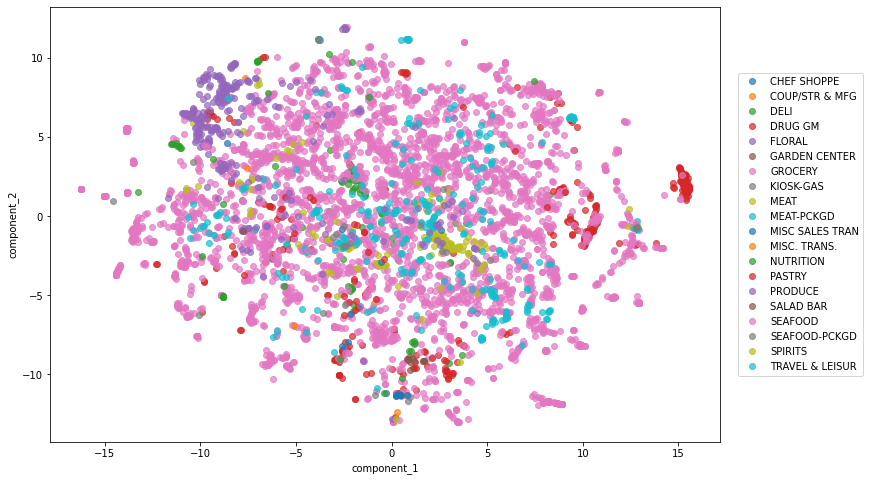

CPU times: user 54.2 s, sys: 3.41 s, total: 57.6 s
Wall time: 7.83 s


In [36]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [37]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

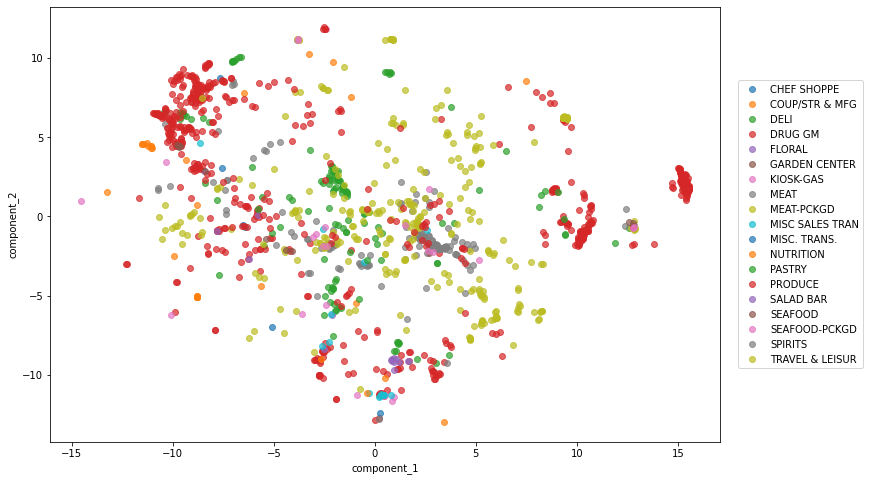

In [38]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Нарисуем все товары в катгеориях, где есть СТМ

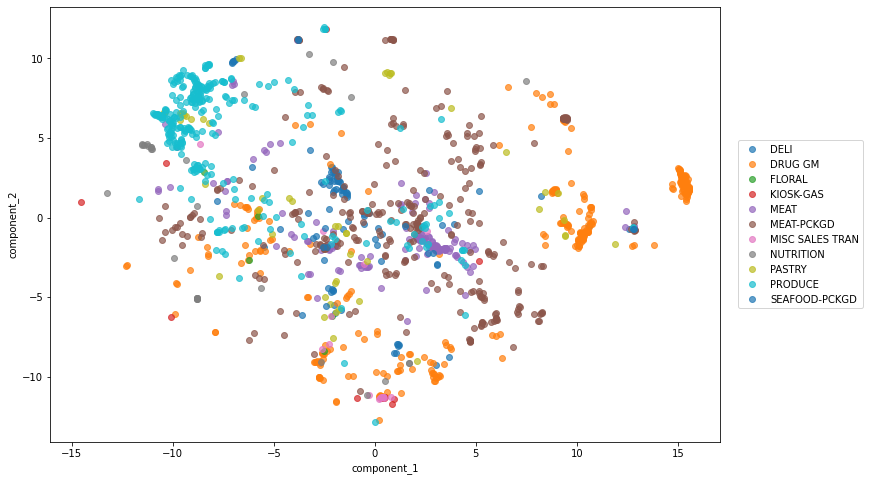

In [39]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

In [40]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [41]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_1,component_2,category,item_id
2433,2.924901,0.786588,PRODUCE,1004906


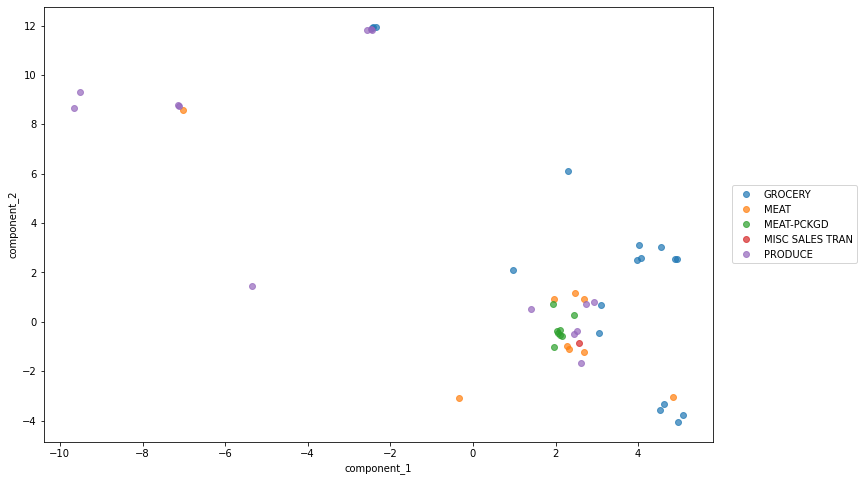

In [42]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [43]:
# your_code

popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

#popularity = popularity[popularity['item_id'] != 999999]

popularity = popularity.groupby('user_id').head(5)

popularity.sort_values('user_id', ascending=False, inplace=True)
popularity.head(2)

,user_id,item_id,quantity
666651,2500,859237,16
666801,2500,999999,556


In [44]:
%%time

def get_rec(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[1][0]
    return id_to_itemid[top_rec]
    

popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec(model, x))
popularity.head(3)

CPU times: user 7.87 s, sys: 1.05 s, total: 8.92 s
Wall time: 1.17 s


,user_id,item_id,quantity,similar_recommendation
666651,2500,859237,16,991951
666801,2500,999999,556,1082185
666867,2500,1065538,10,1034176


In [45]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

,user_id,similar_recommendation
0,1,"[824758, 981760, 999999, 5582712, 1082185]"
1,2,"[8090509, 1082185, 1106523, 5569845, 1133018]"


In [46]:
result = result.merge(recommendation_similar_items, on='user_id', how='left')
result.head(2)

,user_id,actual,bm25,similar_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082212, 1130375, 885290, 898121, 1004390]","[824758, 981760, 999999, 5582712, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[951590, 1110244, 885697, 962229, 883404]","[960318, 1082185, 1076875, 892008]"


### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [26]:
userid_to_id[10]

9

In [47]:
model.similar_users(userid_to_id[10], N=6)

[(9, 1.0),
 (354, 0.7814602),
 (1671, 0.7471172),
 (1765, 0.739534),
 (1549, 0.73442274),
 (289, 0.7192421)]

In [48]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [49]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)


  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 750 ms, sys: 41.1 ms, total: 791 ms
Wall time: 869 ms


In [50]:
get_recommendations(user=1, model=own, sparse_user_item=csr_matrix(user_item_matrix).T.tocsr(), N=1)

[1009368]

-----

# Production

Вы можете дополнить функцию prefilter_items (в начале вебинара): 
- Убрать товары, которые не продавались за последние 12 месяцев
- Убрать не интересные для рекоммендаций категории (department)

и тд

Однако пока это не необходимо

In [51]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
def get_similar_items_recommendation(user, model, N=5):
    """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
    
    # your_code
    
    return res

In [ ]:
def get_similar_users_recommendation(user, model, N=5):
    """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
    
    # your_code
    
    return res

https://arxiv.org/pdf/1902.07243.pdf